In [10]:
import copy
import json
import lightgbm as lgb
import numpy as np
import os
import pandas as pd
import pprint
import shap
import sys

from collections import Counter
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.utils import compute_class_weight

sys.path.insert(0, os.path.join(os.getcwd()))
from model_utils import *

pp = pprint.PrettyPrinter(indent=4)

## Read Config

In [11]:
config_path = '../../config/config.json'
with open(config_path, "r") as cnf:
    config = json.load(cnf)

## Constants

In [12]:
PATH_TO_DATA_SPLITS = config["data_splits"]
PATH_TO_CELLPROFILER_SPLITS_OUTPUT = os.path.join(PATH_TO_DATA_SPLITS, "custom_splits/cellprofiler/stardist_patch_num=4")

PATH_TO_TRAIN = os.path.join(PATH_TO_CELLPROFILER_SPLITS_OUTPUT, "train.csv")
PATH_TO_VAL = os.path.join(PATH_TO_CELLPROFILER_SPLITS_OUTPUT, "val.csv")
PATH_TO_TEST = os.path.join(PATH_TO_CELLPROFILER_SPLITS_OUTPUT, "test.csv")

In [13]:
enable_dlbcl_classification = False
enable_normalization = True

NUM_CLASSES = 9
if enable_dlbcl_classification:
    NUM_CLASSES = 2

SAVE_DATA = False
MODEL_SAVE_PATH = os.path.join(config["predictions"], "section_1_1_nuclei.csv")

## Read Data

In [14]:
def convert_to_patient_id(image):
    return "_".join(image.split("-")[0].split("_")[:-1])

In [15]:
train_features_df = pd.read_csv(PATH_TO_TRAIN)
train_features_df["patient_id"] = train_features_df["Image"].apply(convert_to_patient_id)

val_features_df = pd.read_csv(PATH_TO_VAL)
val_features_df["patient_id"] = val_features_df["Image"].apply(convert_to_patient_id)

test_features_df = pd.read_csv(PATH_TO_TEST)
test_features_df["patient_id"] = test_features_df["Image"].apply(convert_to_patient_id)

In [16]:
columns = list(train_features_df.columns)
columns_to_remove = ["Image", "patient_id", "tma_id", "label", "split", "NormalizedMoment", "count",
                     "Unnamed", "nucleiObjectNumber", "cytoplasmObjectNumber"]
for column_name in columns_to_remove:
    columns = list(filter(lambda col: not(column_name in col), columns))
all_features = columns

## Get Features of Type

In [7]:
feature_types = set(list(map(lambda s : s.split("_")[0], all_features)))

In [8]:
nuclei_features = get_nuclei_morphological_features(all_features)
nuclei_intensity_features = get_nuclei_intensity_features(all_features)
nuclei_cyto_features = get_nuclei_cytoplasm_morphological_features(all_features)

In [9]:
all_features = nuclei_features

## Setup Data Splits

In [10]:
(train_proc_features_df, val_proc_features_df, test_proc_features_df) = get_processed_df_splits(train_features_df, val_features_df,
                                                                                                test_features_df, all_features)
(X_train, y_train, X_test, y_test, scaler) = get_splits(train_features_df, val_features_df, test_features_df, 
                                                        all_features, enable_dlbcl_classification, enable_normalization)

In [11]:
train_df = pd.concat([train_proc_features_df, val_proc_features_df]).reset_index(drop=True)
test_df = test_proc_features_df

## Train/Eval Models

### Parameters

In [12]:
classes = list(range(NUM_CLASSES))
class_weight = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weight))

### Sklearn LGBM Classifier

In [13]:
model = lgb.LGBMClassifier(class_weight="balanced", n_estimators=1000, max_depth=20)
model.fit(X_train, y_train)
train_preds_patch = model.predict(X_train)
test_preds_patch = model.predict(X_test)

train_accuracy_patch = compute_accuracy(train_preds_patch, y_train)
test_accuracy_patch = compute_accuracy(test_preds_patch, y_test)
print(f"PATCH Training accuracy: {train_accuracy_patch}, Test accuracy: {test_accuracy_patch}")

PATCH Training accuracy: 1.0, Test accuracy: 0.5290697674418605


In [14]:
(y_train_core, train_preds_core, train_accuracy_core) = get_core_metrics(train_df, train_preds_patch)
(y_test_core, test_preds_core, test_accuracy_core) = get_core_metrics(test_df, test_preds_patch)
print(f"CORE Training Accuracy: {train_accuracy_core}, Test accuracy: {test_accuracy_core}")

CORE Training Accuracy: 1.0, Test accuracy: 0.5813953488372093


## LightGBM Train API

In [13]:
lgbtrain = lgb.Dataset(X_train, y_train, free_raw_data=True)
lgbeval = lgb.Dataset(X_test, y_test)

params = {'learning_rate': 0.1,
          'num_boost_round':100,
          'num_class':NUM_CLASSES,
          'max_depth':-1,
          'num_leaves':15,
          'verbose': -1}

In [15]:
alpha = class_weight / sum(class_weight)

focal_loss = lambda x,y: focal_loss_lgb(x, y, alpha, 2., NUM_CLASSES)
eval_error = lambda x,y: focal_loss_lgb_eval_error(x, y, alpha, 2., NUM_CLASSES)

model = lgb.train(params, lgbtrain, valid_sets=[lgbeval], fobj=focal_loss,
                  feval=[eval_metric(NUM_CLASSES), eval_error],
                  verbose_eval=False)

Found `num_boost_round` in params. Will use it instead of argument
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


### Patch-Level Metrics

In [16]:
train_preds_patch = get_lgb_preds(model, X_train)
train_accuracy_patch = accuracy_score(y_train, train_preds_patch)
test_preds_patch = get_lgb_preds(model, X_test)
test_accuracy_patch = accuracy_score(y_test, test_preds_patch)

print(f"PATCH Training Accuracy: {train_accuracy_patch}, Test accuracy: {test_accuracy_patch}")

PATCH Training Accuracy: 0.9694835680751174, Test accuracy: 0.5116279069767442


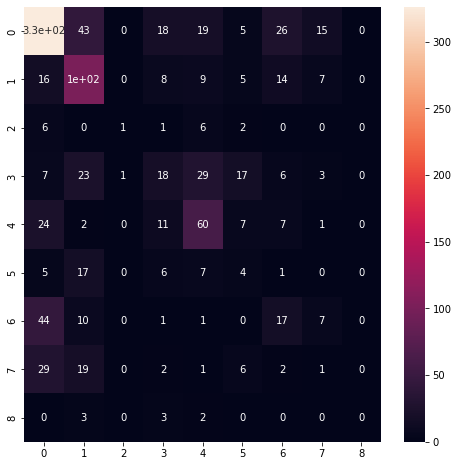

In [17]:
cnf_matrix = confusion_matrix(y_test, test_preds_patch)
plot_confusion_matrix(cnf_matrix, NUM_CLASSES)

### Core-Level Metrics

In [18]:
(y_train_core, train_preds_core, train_accuracy_core) = get_core_metrics(train_df, train_preds_patch, enable_dlbcl_classification)
(y_test_core, test_preds_core, test_accuracy_core) = get_core_metrics(test_df, test_preds_patch, enable_dlbcl_classification)
print(f"CORE Training Accuracy: {train_accuracy_core}, Test accuracy: {test_accuracy_core}")

CORE Training Accuracy: 0.9873949579831933, Test accuracy: 0.5968992248062015


In [19]:
train_pred_probs = get_lgb_pred_probs(model, X_train)
test_pred_probs = get_lgb_pred_probs(model, X_test)

(y_train_core, train_preds_core, train_accuracy_core) = get_core_metrics_mean(train_df, train_pred_probs, NUM_CLASSES)
(y_test_core, test_preds_core, test_accuracy_core) = get_core_metrics_mean(test_df, test_pred_probs, NUM_CLASSES)
print(f"CORE Training Accuracy: {train_accuracy_core}, Test accuracy: {test_accuracy_core}")

CORE Training Accuracy: 0.9894957983193278, Test accuracy: 0.5891472868217055


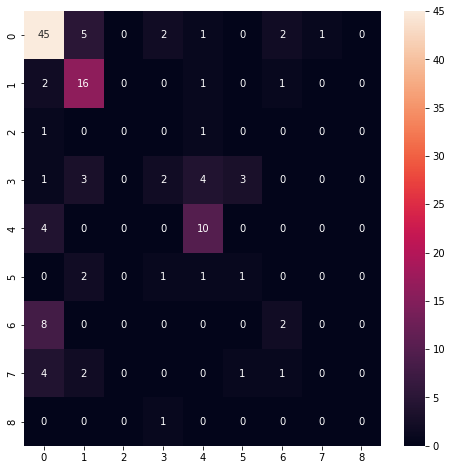

In [20]:
cnf_matrix = confusion_matrix(y_test_core, test_preds_core)
plot_confusion_matrix(cnf_matrix, NUM_CLASSES)

In [21]:
test_df["test_preds"] = test_preds_patch
print(f'''Training Accuracy: {train_accuracy_core}, Test accuracy: {test_accuracy_core}''')
(macro_f1, micro_f1, weighted_f1) = get_f1_scores(y_test_core, test_preds_core)
cnf_matrix = get_confusion_matrix(y_test_core, test_preds_core)
test_metrics = build_metrics_dict(False, train_accuracy_core, test_accuracy_core, 
                                  macro_f1, micro_f1, weighted_f1, cnf_matrix)
pp.pprint(test_metrics)

Training Accuracy: 0.9894957983193278, Test accuracy: 0.5891472868217055
{   'cnf_matrix': array([[45,  5,  0,  2,  1,  0,  2,  1,  0],
       [ 2, 16,  0,  0,  1,  0,  1,  0,  0],
       [ 1,  0,  0,  0,  1,  0,  0,  0,  0],
       [ 1,  3,  0,  2,  4,  3,  0,  0,  0],
       [ 4,  0,  0,  0, 10,  0,  0,  0,  0],
       [ 0,  2,  0,  1,  1,  1,  0,  0,  0],
       [ 8,  0,  0,  0,  0,  0,  2,  0,  0],
       [ 4,  2,  0,  0,  0,  1,  1,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  0]]),
    'macro_f1': 0.29955495948318916,
    'micro_f1': 0.5891472868217055,
    'test_acc': 0.5891472868217055,
    'train_acc': 0.9894957983193278,
    'weighted_f1': 0.5424268837254261}


### Patch-Based Quality Control Threshold (PQC) 

In [22]:
label_cols = [str(x) for x in range(NUM_CLASSES)]
test_pred_probs_df = pd.DataFrame(test_pred_probs, columns=label_cols)
test_pred_probs_df = pd.concat([test_df[["patient_id", "label"]], test_pred_probs_df], axis=1)              

In [23]:
PQC_THRESHOLD = 0.7

#### Patch-Level Metrics

In [24]:
def get_pqc_patch_accuracy():
    num_correct, num_total = 0, 0
    for (test_pred_probs_i, y_test_i) in zip(test_pred_probs, y_test):
        if max(test_pred_probs_i) <= PQC_THRESHOLD:
            continue
        if test_pred_probs_i.argmax() == y_test_i:
            num_correct += 1
        num_total += 1
    print(f"PATCH Test accuracy: {num_correct} / {num_total} = {num_correct / num_total}")

get_pqc_patch_accuracy()

PATCH Test accuracy: 104 / 129 = 0.8062015503875969


#### Core-Level Metrics

In [25]:
def build_pqc_maps():
    # Returns: 
    # 1) # Map from patient ID to ground-truth label
    # 2) Map from patient ID to list of predictions (one for each patch with max_prob >= threshold)
    patient_to_label = dict()
    patient_to_preds = dict()
    for index, row in test_pred_probs_df.iterrows():
        patient_id = row["patient_id"]
        label = row["label"]
        if patient_id in patient_to_label:
            assert(patient_to_label[patient_id] == label)
        else:
            patient_to_label[patient_id] = label

        max_prob = max(row[label_cols])
        if max_prob <= PQC_THRESHOLD:
            continue
        pred = np.argmax(row[label_cols])
        if patient_id not in patient_to_preds:
            patient_to_preds[patient_id] = []
        patient_to_preds[patient_id].append(pred)
    return patient_to_label, patient_to_preds

patient_to_label, patient_to_preds = build_pqc_maps()

In [26]:
def get_pqc_core_accuracy(patient_to_label, patient_to_preds):
    y_true = []
    y_pred = []
    num_correct, num_total = 0, 0
    for patient_id, label in patient_to_label.items():
        if patient_id not in patient_to_preds:
            continue
        preds = patient_to_preds[patient_id]
        pred = pd.Series.mode(preds)[0]
        if label == pred:
            num_correct += 1
        num_total += 1
        y_pred.append(pred)
        y_true.append(label)
    print(f"CORE Test accuracy: {num_correct} / {num_total} = {num_correct / num_total}")
    return (y_pred, y_true)

y_pred, y_true = get_pqc_core_accuracy(patient_to_label, patient_to_preds)

CORE Test accuracy: 39 / 51 = 0.7647058823529411


In [27]:
cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix

array([[30,  1,  0,  0,  1,  1,  0],
       [ 0,  6,  0,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  0,  0],
       [ 1,  0,  0,  2,  0,  0,  0],
       [ 3,  0,  0,  0,  0,  0,  0],
       [ 3,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  0,  0]])

## Save Model Outputs on Test Set

In [28]:
model_df = pd.concat([y_test_core, test_preds_core], axis=1).reset_index()
model_df.columns = ["patient_id", "label", "prediction"]
if SAVE_DATA:
    model_df.to_csv(MODEL_SAVE_PATH)

## Classification Report

In [29]:
## Create classification report, with test accuracy and weighted F1 per class.
target_names = ['DLBCL', 'HL', 'Agg BCL', 'FL', 'MCL', 'MZL', 'NKTCL', 'TCL', 'Nonmalignant']
print(classification_report(y_test_core, test_preds_core, target_names=target_names))

              precision    recall  f1-score   support

       DLBCL       0.69      0.80      0.74        56
          HL       0.57      0.80      0.67        20
     Agg BCL       0.00      0.00      0.00         2
          FL       0.33      0.15      0.21        13
         MCL       0.56      0.71      0.63        14
         MZL       0.20      0.20      0.20         5
       NKTCL       0.33      0.20      0.25        10
         TCL       0.00      0.00      0.00         8
Nonmalignant       0.00      0.00      0.00         1

    accuracy                           0.59       129
   macro avg       0.30      0.32      0.30       129
weighted avg       0.52      0.59      0.54       129



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


## Cross Validation

### Cross-Validation Utilities

In [30]:
def get_cv_processed_df_splits(feature_cols, train_df, val_df):
    train_df = train_df[feature_cols + ["patient_id", "label"]].dropna().reset_index(drop=True)
    val_df = val_df[feature_cols + ["patient_id", "label"]].dropna().reset_index(drop=True)
    return (train_df, val_df)

def get_cv_splits_from_df(feature_cols, train_df, val_df):
    X_train = train_df[feature_cols].astype(np.float32)
    y_train = train_df["label"]
    X_val = val_df[feature_cols].astype(np.float32)
    y_val = val_df["label"]
    
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_val = scaler.transform(X_val)
    return (X_train, y_train, X_val, y_val)

def setup_cv_splits(X_patients, y_patients, train_idx, val_idx):
    train_patients = X_patients[train_idx]
    val_patients = X_patients[val_idx]
    cv_train_df = train_df.loc[train_df['patient_id'].isin(train_patients)]
    cv_val_df = train_df.loc[train_df['patient_id'].isin(val_patients)]
    (cv_train_df, cv_val_df) = get_cv_processed_df_splits(all_features, cv_train_df, cv_val_df)
    (X_train, y_train, X_val, y_val) = get_cv_splits_from_df(all_features, cv_train_df, cv_val_df)
    return X_train, y_train, X_val, y_val, cv_train_df, cv_val_df
        
def compute_metrics(model, cv_val_df, X_val, y_val):
    val_preds_patch = get_lgb_preds(model, X_val)
    val_accuracy_patch = accuracy_score(y_val, val_preds_patch)
    (macro_f1_patch, micro_f1_patch, weighted_f1_patch) = get_f1_scores(y_val, val_preds_patch)
    (y_val_core, val_preds_core, val_accuracy_core) = get_core_metrics(cv_val_df, val_preds_patch)
    (macro_f1_core, micro_f1_core, weighted_f1_core) = get_f1_scores(y_val_core, val_preds_core)  
    return (val_accuracy_patch, val_accuracy_core, weighted_f1_patch, weighted_f1_core)

### Get Lists of All Patients and their Labels in Training Set

In [31]:
train_df = pd.concat([train_features_df, val_features_df]).reset_index(drop=True)
train_df["patient_id"] = train_df["Image"].apply(convert_to_patient_id)

train_patients = train_df["patient_id"]
train_labels = train_df["label"]

In [32]:
X_patients = []
y_patients = []
seen_patients = set()
for patient, label in zip(train_patients, train_labels):
    if patient in seen_patients:
        continue
    X_patients.append(patient)
    y_patients.append(label)
    seen_patients.add(patient)
X_patients = np.array(X_patients)
y_patients = np.array(y_patients)

### Setup Parameters

In [33]:
class_weight = compute_class_weight('balanced', classes=classes, y=y_patients)
alpha = class_weight / sum(class_weight)

focal_loss = lambda x,y: focal_loss_lgb(x, y, alpha, 2., NUM_CLASSES)
eval_error = lambda x,y: focal_loss_lgb_eval_error(x, y, alpha, 2., NUM_CLASSES)

### Run Cross Validation

In [34]:
def run_cv(num_folds=5, debug=True):
    folds = StratifiedKFold(num_folds, shuffle=True, random_state=0)
    val_patch_scores, val_core_scores = [], []
    val_patch_f1_scores, val_core_f1_scores = [], []

    for train_idx, val_idx in folds.split(X_patients, y_patients):
        ## Setup Cross-Val Data Splits
        X_train, y_train, X_val, y_val, cv_train_df, cv_val_df = setup_cv_splits(X_patients, y_patients, train_idx, val_idx)

        ## Train and Evaluate LightGBM Model
        lgbtrain = lgb.Dataset(X_train, y_train)
        lgbeval = lgb.Dataset(X_val, y_val)
        model = lgb.train(params, lgbtrain, valid_sets=[lgbeval],
                          fobj=focal_loss,feval=[eval_metric(NUM_CLASSES), eval_error],
                          verbose_eval=False)

        ## Get Predictions and Compute Metrics
        val_accuracy_patch, val_accuracy_core, weighted_f1_patch, weighted_f1_core = compute_metrics(model, cv_val_df, X_val, y_val)
        val_patch_scores.append(val_accuracy_patch)
        val_core_scores.append(val_accuracy_core)
        val_patch_f1_scores.append(weighted_f1_patch)
        val_core_f1_scores.append(weighted_f1_core)

    ## Print Outputs
    if debug:
        print('Val patch scores: ', val_patch_scores)
        print('Val patch f1 scores: ', val_patch_f1_scores)
        print('Val core scores: ', val_core_scores)
        print('Val core f1 scores: ', val_core_f1_scores)
        print('Average Val patch score: ', np.mean(np.array(val_patch_scores)))
        print('Average Val core score: ', np.mean(np.array(val_core_scores)))
        print('Average Val patch f1 score: ', np.mean(np.array(val_patch_f1_scores)))
        print('Average Val core f1 score: ', np.mean(np.array(val_core_f1_scores)))
    return val_core_scores, val_core_f1_scores

val_core_scores, val_patch_scores = run_cv()

The least populated class in y has only 2 members, which is less than n_splits=5.
Found `num_boost_round` in params. Will use it instead of argument
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Found `num_boost_round` in params. Will use it instead of argument
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Found `num_boost_round` in params. Will use it instead of argument
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Found `num_boost_round` in params. Will use it instead of argument
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Found `num_boost_r

Val patch scores:  [0.474937343358396, 0.4712041884816754, 0.525065963060686, 0.5314591700133868, 0.4876140808344198]
Val patch f1 scores:  [0.4711398731032174, 0.45242070346220437, 0.5157259160573764, 0.5130769260788389, 0.4797584420161183]
Val core scores:  [0.5416666666666666, 0.5368421052631579, 0.6, 0.6210526315789474, 0.5578947368421052]
Val core f1 scores:  [0.5213149641577061, 0.4875828747950672, 0.5561585207003977, 0.5640729825771377, 0.5247626312157205]
Average Val patch score:  0.4980561491497128
Average Val core score:  0.5714912280701754
Average Val patch f1 score:  0.48642437214355105
Average Val core f1 score:  0.5307783946892058
